In [9]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import torch
from coherenceModel import *
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
paragraph_df = pd.read_csv('aviationPerms.csv')
paragraph_df

,paragraph,is_coherent
0,The preflight inspection of the fuel tanks by ...,1
1,"The pilot reported that he was cleared to 4,00...",1
2,The instrument-rated private pilot lost contro...,1
3,The non-instrument rated private pilot was rec...,1
4,The commercial pilot reported a partial power ...,1
...,...,...
2095,THE FUEL SELECTOR WAS POSITIONED ON THE RIGHT ...,0
2096,DURING AN INTENTIONAL MANEUVER TO AVOID A HOME...,0
2097,RESIDUAL FUEL WAS FOUND IN THE CARBURETOR BOWL...,0
2098,"AT A 75% POWER SETTING, FUEL FLOW IS ABOUT 10....",0


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    paragraph_df.paragraph.values, 
    paragraph_df.is_coherent.values,
    stratify = paragraph_df.is_coherent.values,
    test_size = 0.1, 
    random_state = 487
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, 
    y_train,
    stratify = y_train,
    test_size = 0.2, 
    random_state = 487
)
print(X_train[0])
print(y_train[0])

Routine air work was performed and then touch-and-go landing practice was planned. The approach and landing on runway 34 was normal. During the takeoff roll the pilot noticed that unusual stick forces were required to raise the tail wheel. FAA inspectors examined the airplane and did not report finding any trim or control system irregularity; however, the fuselage distortion precluded a complete examination. He saw a row of sailplanes parked on runway 30 in his path and elected to turn off the runway into sagebrush and grass. He decided to abort the takeoff and applied forward stick to prevent the airplane from leaping off the runway in a stalled condition. The trim setting was rechecked and confirmed. The pilot added some additional nose down trim, but no relief of stick pressure was noticed. He was drifting to the right and approaching the intersection of runway 30 at this time. The right main landing gear fell into a ditch and collapsed, buckling and distorting the fuselage. Trim wa

In [96]:
import gensim.downloader
embed = gensim.downloader.load("glove-wiki-gigaword-50")

[==================================================] 100.0% 66.0/66.0MB downloaded


In [147]:
train_data = WindowedParDataset(X_train, y_train, embed, 5)
dev_data = WindowedParDataset(X_val, y_val, embed, 5)
test_data = WindowedParDataset(X_test, y_test, embed, 5)

In [148]:
train_loader = DataLoader(train_data, batch_size=25, collate_fn=basic_collate_fn, shuffle=True)
dev_loader = DataLoader(dev_data, batch_size=25, collate_fn=basic_collate_fn, shuffle=True)
test_loader = DataLoader(test_data, batch_size=25, collate_fn=basic_collate_fn, shuffle=False)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [115]:
num_pos = len(paragraph_df[paragraph_df["is_coherent"] == 1])
num_neg = len(paragraph_df[paragraph_df["is_coherent"] == 0])
pos_weight = torch.Tensor([num_neg / num_pos]).to(device)
pos_weight

tensor([20.], device='cuda:0')

------------------------ Start Training ------------------------
Epoch No. 1--Iteration No. 106-- batch loss = 2.9887
Validation UAR: 0.6250
Validation accuracy: 0.8242
Validation loss: 1.2751
Epoch No. 2--Iteration No. 212-- batch loss = 2.1764
Validation UAR: 0.6833
Validation accuracy: 0.4039
Validation loss: 1.1810
Epoch No. 3--Iteration No. 318-- batch loss = 1.4397
Validation UAR: 0.7359
Validation accuracy: 0.6048
Validation loss: 0.9848
Epoch No. 4--Iteration No. 424-- batch loss = 0.5504
Validation UAR: 0.7886
Validation accuracy: 0.7696
Validation loss: 0.8468
Epoch No. 5--Iteration No. 530-- batch loss = 0.6633
Validation UAR: 0.8008
Validation accuracy: 0.8647
Validation loss: 0.7859
Epoch No. 6--Iteration No. 636-- batch loss = 0.5263
Validation UAR: 0.8761
Validation accuracy: 0.7999
Validation loss: 0.6641
Epoch No. 7--Iteration No. 742-- batch loss = 0.7963
Validation UAR: 0.8824
Validation accuracy: 0.7905
Validation loss: 0.6253
Epoch No. 8--Iteration No. 848-- batch 

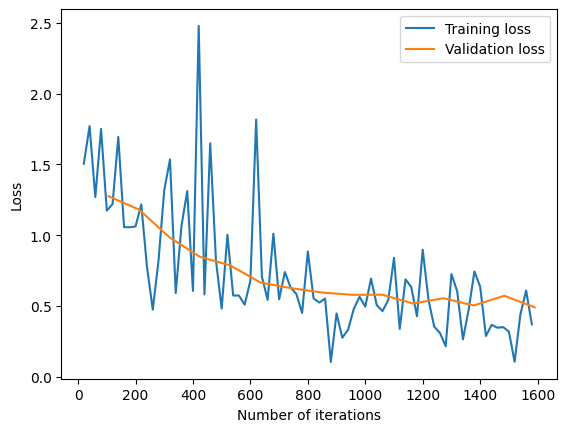

In [165]:
# test on validation to see if overfit is possible
ffnn = FFNN(5, device)
ffnn.to(device)
optim = get_optimizer(ffnn, lr=1e-2, weight_decay=0)
best_model, stats = train_model(ffnn, dev_loader, dev_loader, optim, pos_weight=pos_weight,
                                num_epoch=15, collect_cycle=20, device=device, patience=None)
plot_loss(stats)

In [166]:
################ SET THIS TO CHANGE WINDOW SIZE OF THINGS BELOW:
wsize = 5
################
train_data = WindowedParDataset(X_train, y_train, embed, wsize)
dev_data = WindowedParDataset(X_val, y_val, embed, wsize)
test_data = WindowedParDataset(X_test, y_test, embed, wsize)
train_loader = DataLoader(train_data, batch_size=25, collate_fn=basic_collate_fn, shuffle=True)
dev_loader = DataLoader(dev_data, batch_size=25, collate_fn=basic_collate_fn, shuffle=True)
test_loader = DataLoader(test_data, batch_size=25, collate_fn=basic_collate_fn, shuffle=False)

In [ ]:
import itertools
from tqdm.notebook import tqdm

torch.cuda.empty_cache()

def search_param_utterance(wsize):
    """Experiemnt on different hyper parameters."""
    learning_rate, weight_decay = get_hyper_parameters()
    window_sizes = [wsize]
    print("learning rate from: {}\nweight_decay from: {}\nwindow from: {}".format(
        learning_rate, weight_decay, window_sizes
    ))
    best_model, best_stats = None, None
    best_accuracy, best_lr, best_wd, best_window_size = 0, 0, 0, 0
    for lr, wd, window_size in tqdm(itertools.product(learning_rate, weight_decay, window_sizes),
                           total=len(learning_rate) * len(weight_decay) * len(window_sizes)):
        net = FFNN(window_size, device).to(device)
        optim = get_optimizer(net, lr=lr, weight_decay=wd)
        model, stats = train_model(net, train_loader, dev_loader, optim, pos_weight=pos_weight, 
                                   num_epoch=100, collect_cycle=500, device=device, 
                                   verbose=True, patience=25, stopping_criteria='accuracy')
        # print accuracy
        print(f"{(lr, wd, window_size)}: {stats['accuracy']}")
        # update best parameters if needed
        if stats['accuracy'] > best_accuracy:
            best_accuracy = stats['accuracy']
            best_model, best_stats = model, stats
            best_lr, best_wd, best_window_size = lr, wd, window_size
            torch.save(best_model.state_dict(), 'best_rnn.pt')
    print("\n\nBest learning rate: {}, best weight_decay: {}, best window: {}".format(
        best_lr, best_wd, best_window_size))
    print("Accuracy: {:.4f}".format(best_accuracy))
    plot_loss(best_stats)
    return best_model
basic_model = search_param_utterance(5)

learning rate from: [0.01]
weight_decay from: [0.01, 0.1, 0.25, 0.5, 1.0, 1.25, 2.0, 2.5, 5.0]
window from: [5]


  0%|          | 0/9 [00:00<?, ?it/s]

------------------------ Start Training ------------------------
Epoch No. 1--Iteration No. 422-- batch loss = 0.5795
Validation UAR: 0.5000
Validation accuracy: 0.9523
Validation loss: 1.3440
Epoch No. 2--Iteration No. 844-- batch loss = 0.7199
Validation UAR: 0.4967
Validation accuracy: 0.8454
Validation loss: 1.3203
Epoch No. 3--Iteration No. 1266-- batch loss = 0.5908
Validation UAR: 0.5000
Validation accuracy: 0.9523
Validation loss: 1.3428
Epoch No. 4--Iteration No. 1688-- batch loss = 0.7395
Validation UAR: 0.5022
Validation accuracy: 0.0519
Validation loss: 1.3245
Epoch No. 5--Iteration No. 2110-- batch loss = 7.7145
Validation UAR: 0.4943
Validation accuracy: 0.1016
Validation loss: 1.3238
Epoch No. 6--Iteration No. 2532-- batch loss = 0.6943
Validation UAR: 0.4996
Validation accuracy: 0.7075
Validation loss: 1.3237
Epoch No. 7--Iteration No. 2954-- batch loss = 0.6977
Validation UAR: 0.4981
Validation accuracy: 0.8624
Validation loss: 1.3199
Epoch No. 8--Iteration No. 3376-- 

In [ ]:
uar, accuracy, total_loss = get_validation_performance(
    basic_model, 
    nn.BCEWithLogitsLoss(pos_weight=pos_weight), 
    test_loader, 
    device
)
print("Test UAR: {:.4f}".format(uar))
print("Test accuracy: {:.4f}".format(accuracy))
print("Test loss: {:.4f}".format(loss))